# 3_ClimateForecasting
In this notebook, we read in the results of the climate model tuning process, train a model based on this, evaluate it on the test set, then generate the multiple sets of climate forecasts needed for the dengue model tuning and training process. 

In [1]:
import pandas as pd
import numpy as np
import torch 
import os
import json

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.metrics import mape, smape, mse, rmse, mae, mql, ql
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.samplers import TPESampler
from darts.models import (
    RandomForestModel,
    LinearRegressionModel,
    XGBModel
)
from darts.utils.likelihood_models import GaussianLikelihood, PoissonLikelihood, QuantileRegression
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback, EarlyStopping
import pickle
import helpers as hp

pd.options.mode.copy_on_write = True
random_seed = 20


# 1. Reading Input

In [2]:
tuning_name = "Notebook_24_07_2025"
base_dir = os.getcwd()
model_input_dir = os.path.join(base_dir, "ModelInput")
tuning_dir = os.path.join(base_dir, "Climate Tuning", tuning_name)

weekly_cal = pd.read_csv(os.path.join(model_input_dir, "Calendar.csv"))
climate_df = pd.read_csv(os.path.join(model_input_dir, "TimeVaryingCovs.csv"))

#Remove uf = "ES" since there is no dengue data for Espirito Santo
climate_df = climate_df[climate_df["uf"] != "ES"]

In [3]:
model_to_read = "RandomForest"
tuning_res_dir = os.path.join(tuning_dir, model_to_read)
forecast_res_dir = os.path.join(tuning_res_dir, "Forecasts")
os.makedirs(forecast_res_dir, exist_ok = True)
model_best_params = hp.read_json(os.path.join(tuning_res_dir, "best_params.json"))
tuning_config = hp.read_json(os.path.join(tuning_dir, "tuning_details.json"))

clim_var_names = tuning_config["clim_var_names"]
global_scale = tuning_config["global_scale"]
retrain_per_fold = tuning_config["retrain_per_fold"] 
approach = tuning_config["approach"]
use_orig_scaler = False #If we use the original scaler during tuning to rescale values
use_orig_normer = True #Use the original train1 series (same as tuning) for the normalisation of error metrics - makes test loss comparable with validation loss

In [4]:
#Define set info used to split the data into different sets. This section should ideally align with what was used during hype
set_info = weekly_cal[["epiweek", "Year", "Week", "WeekStart", "WeekMid", "WeekEnd"]]
set_info = set_info.iloc[1:]

#Define the data sets using a column of booleans in the calendar. 
#all epiweek numbers are in YYYYWW integer format
set_info["clim_train1"] = set_info["epiweek"] <= 201510
set_info["clim_val1"] = (set_info["epiweek"] >= 201526) & (set_info["epiweek"] <= 201625)
set_info["clim_train2"] = set_info["epiweek"] <= 201610
set_info["clim_val2"] = (set_info["epiweek"] >= 201626) & (set_info["epiweek"] <= 201725)
set_info["clim_train3"] = set_info["epiweek"] <= 201710
set_info["clim_val3"] = (set_info["epiweek"] >= 201726) & (set_info["epiweek"] <= 201825)
set_info["clim_test"] = (set_info["epiweek"] >= 201841) & (set_info["epiweek"] <= 201940)
set_info["clim_test_input"] = set_info["epiweek"] <= 201825
set_info

,epiweek,Year,Week,WeekStart,WeekMid,WeekEnd,clim_train1,clim_val1,clim_train2,clim_val2,clim_train3,clim_val3,clim_test,clim_test_input
1,201001,2010,1,2010-01-03,2010-01-07,2010-01-09,True,False,True,False,True,False,False,True
2,201002,2010,2,2010-01-10,2010-01-14,2010-01-16,True,False,True,False,True,False,False,True
3,201003,2010,3,2010-01-17,2010-01-21,2010-01-23,True,False,True,False,True,False,False,True
4,201004,2010,4,2010-01-24,2010-01-28,2010-01-30,True,False,True,False,True,False,False,True
5,201005,2010,5,2010-01-31,2010-02-04,2010-02-06,True,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,202523,2025,23,2025-06-01,2025-06-05,2025-06-07,False,False,False,False,False,False,False,False
806,202524,2025,24,2025-06-08,2025-06-12,2025-06-14,False,False,False,False,False,False,False,False
807,202525,2025,25,2025-06-15,2025-06-19,2025-06-21,False,False,False,False,False,False,False,False
808,202526,2025,26,2025-06-22,2025-06-26,2025-06-28,False,False,False,False,False,False,False,False


In [5]:
uf_list = climate_df["uf"].unique()
uf_mapper = climate_df[["uf", "uf_name"]].copy().drop_duplicates()
uf_dict = dict(zip(uf_mapper["uf"], uf_mapper["uf_name"]))
uf_name_list = [uf_dict[curr_uf] for curr_uf in uf_list]

# 2. Data Preparation

In [6]:
#Get a version of the climate DataFrame where the precipiation related variables have been log transformed
log_trans_cols = ["precip_min", "precip_med", "precip_max"]
proc_climate_df = hp.transform_df_cols(climate_df, log_trans_cols, np.log1p)

In [7]:
group_col = "uf"

#Training set without the pre-processing, mainly for normalising error metrics
train1 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_train1")
train2 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_train2")
train3 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_train3")

#Training sets with pre-processing for actual model training
train1_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_train1")
train2_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_train2")
train3_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_train3")

#Note that since the validation and test sets are only used for evaluation / error calculation, we use the non pre-processed version (no log-transforms) 
val1 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_val1")
val2 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_val2")
val3 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_val3")

eval_train = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_test_input")
eval_train_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_test_input") # Input sequence for the final model to evaluate on test set
test = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "clim_test") #Test set for evaluation

In [8]:
#Original scaler
clim_scaler1 = Scaler(global_fit = global_scale)
clim_scaler1.fit(train1_log)

#Only scale training sets 
train1_log_s = clim_scaler1.transform(train1_log)
train2_log_s = clim_scaler1.transform(train2_log)
train3_log_s = clim_scaler1.transform(train3_log)

#New Scaler
clim_eval_scaler = Scaler(global_fit = global_scale)
if use_orig_scaler:
    eval_train_log_s = clim_scaler1.transform(eval_train_log)
else:
    eval_train_log_s = clim_eval_scaler.fit_transform(eval_train_log)

if use_orig_normer:
    normer = train1
else:
    normer = eval_train

# 3. Fitting Model
We then use the best hyperparameters from the tuning process to fit a model (same type as was tuned), evaluate it against the test set, and then generate the necessary forecasts.

In [9]:
#Cell should match the definitions listed in the tuning process
gap_length = 15

#We use 53 as the base forecast length because some years have 53 weeks
if approach == "forecast_gap": #"Forecast the gap" approach
    output_chunk_length = 1 #We assume 1-step ahead for the forecast the gap approach
    output_chunk_shift = 0
    forecast_length = 53 + gap_length
else: #"One shot forecast" approach
    output_chunk_length = 53 #If we are doing a 1-shot forecast, we set output_chunk_length to 53 since some years have 53 weeks.
    output_chunk_shift = gap_length #We set an output_chunk_shift equal to the gap size
    forecast_length = output_chunk_length

In [10]:
lags = model_best_params["lags"]
encoders = {"datetime_attribute": {"future": ["month", "year"]}, 
                "transformer": Scaler()}

if model_to_read == "LinearRegression":
    main_model = LinearRegressionModel(lags = lags, lags_future_covariates = (lags, output_chunk_length), 
                                       add_encoders = encoders, output_chunk_length = output_chunk_length, 
                                       output_chunk_shift = output_chunk_shift)
elif model_to_read == "RandomForest":
    main_model = RandomForestModel(lags = lags, lags_future_covariates = (lags, output_chunk_length), add_encoders = encoders, 
                                   output_chunk_length = output_chunk_length, output_chunk_shift = output_chunk_shift, 
                                   random_state = random_seed)
else:
    main_model = XGBModel(lags = lags, lags_future_covariates = (lags, output_chunk_length), add_encoders = encoders, 
                                   output_chunk_length = output_chunk_length, output_chunk_shift = output_chunk_shift, 
                                   random_state = random_seed)

In [11]:
main_model.fit(eval_train_log_s)

RandomForestModel(lags=191, lags_past_covariates=None, lags_future_covariates=(191, 1), output_chunk_length=1, output_chunk_shift=0, add_encoders={'datetime_attribute': {'future': ['month', 'year']}, 'transformer': Scaler}, n_estimators=100, max_depth=None, multi_models=True, use_static_covariates=True, random_state=20)

In [12]:
eval_preds_log_s = main_model.predict(series = eval_train_log_s, n = forecast_length)
if use_orig_scaler:
    eval_preds_log = clim_scaler1.inverse_transform(eval_preds_log_s)
else:
    eval_preds_log = clim_eval_scaler.inverse_transform(eval_preds_log_s)

eval_preds = hp.transform_comps_ts_list(eval_preds_log, comps_to_trans = log_trans_cols, trans_func = np.expm1)

In [13]:
test_metrics_summ = hp.generate_series_metrics_table(test, eval_preds, uf_name_list, "uf_name", normer_list = normer, disp_mode = False)
test_metrics_per_comp = hp.generate_component_metric_table(test, eval_preds, uf_name_list, "uf_name", clim_var_names, mae, normer_list = normer)

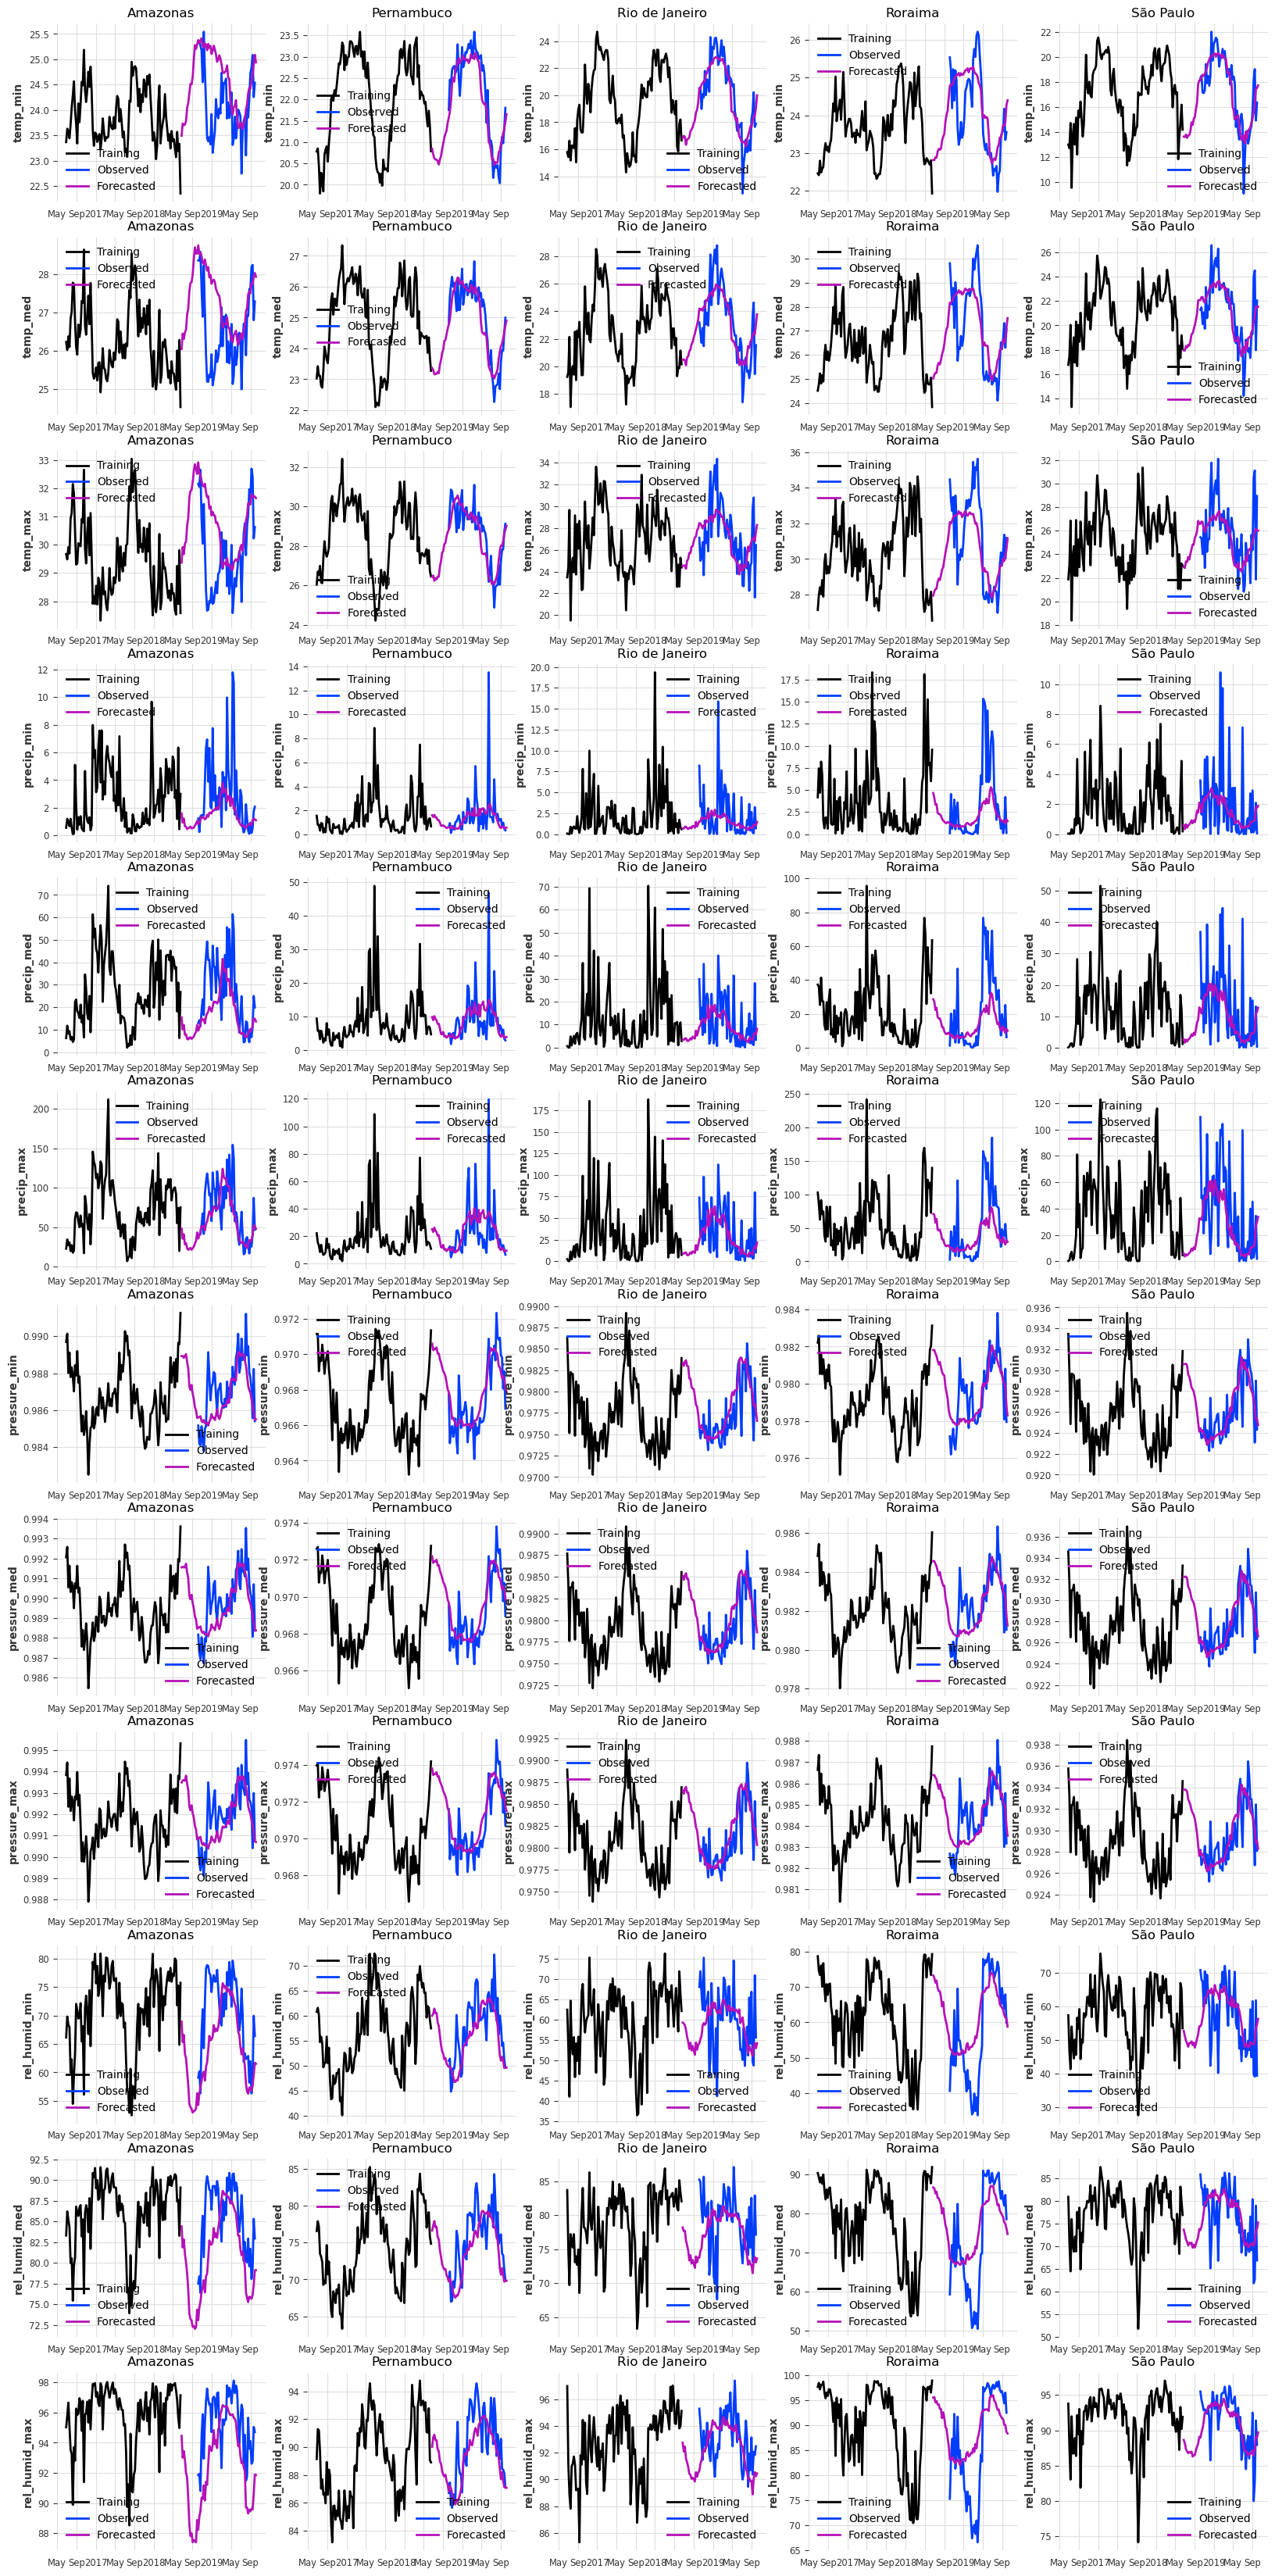

In [14]:
hp.generate_preds_obs_plot(eval_train, test, eval_preds, uf_list, ["PE", "AM", "RJ", "SP", "RR"], clim_var_names, label_list = uf_name_list, train_limit = 104)

# 4. Generating Forecasts
After fitting and evaluating the model, we then generate forecasts. Note that we apply the model that we have evaluated here (we do not retrain it as we generate these forecasts, only changing the input sequence). 

In [15]:
input_set_info = weekly_cal[["epiweek", "Year", "Week", "WeekStart", "WeekMid", "WeekEnd"]]
input_set_info = input_set_info.iloc[1:]

#Sets for input series to generate forecasts to be used during hyperparameter tuning
input_set_info["clim_input_1a"] = input_set_info["epiweek"] <= 201825
input_set_info["clim_input_1b"] = input_set_info["epiweek"] <= 201925
input_set_info["clim_input_1c"] = input_set_info["epiweek"] <= 202025

#Validation sets, which we can also use to see if our forecasts have similar loss to the test and validation sets
input_set_info["clim_val_1a"] = (input_set_info["epiweek"] >= 201841) & (input_set_info["epiweek"] <= 201940)
input_set_info["clim_val_1b"] = (input_set_info["epiweek"] >= 201941) & (input_set_info["epiweek"] <= 202040)
input_set_info["clim_val_1c"] = (input_set_info["epiweek"] >= 202041) & (input_set_info["epiweek"] <= 202140)


#Input sets for generating forecasts for early stopping and validation loss during dengue model training
input_set_info["clim_input_1"] = input_set_info["epiweek"] <= 202110
input_set_info["clim_input_2"] = input_set_info["epiweek"] <= 202210
input_set_info["clim_input_3"] = input_set_info["epiweek"] <= 202310

input_set_info["clim_val_1"] = (input_set_info["epiweek"] >= 202126) & (input_set_info["epiweek"] <= 202225)
input_set_info["clim_val_2"] = (input_set_info["epiweek"] >= 202226) & (input_set_info["epiweek"] <= 202325)
input_set_info["clim_val_3"] = (input_set_info["epiweek"] >= 202326) & (input_set_info["epiweek"] <= 202425)

#Hold sets - which are also used as inputs to generate forecasts over the test sets
input_set_info["clim_hold_1"] = input_set_info["epiweek"] <= 202225
input_set_info["clim_hold_2"] = input_set_info["epiweek"] <= 202325
input_set_info["clim_hold_3"] = input_set_info["epiweek"] <= 202425

#Targets - to evaluate the model output when hold sets are inputs. Forecasts over targets used in evaluating the model
input_set_info["clim_target_1"] = (input_set_info["epiweek"] >= 202241) & (input_set_info["epiweek"] <= 202340)
input_set_info["clim_target_2"] = (input_set_info["epiweek"] >= 202341) & (input_set_info["epiweek"] <= 202440)
input_set_info["clim_target_3"] = (input_set_info["epiweek"] >= 202441) & (input_set_info["epiweek"] <= 202540)

In [16]:
#Create all the TimeSeries (both raw and log-transformed versions)

#For tuning
#Input 1a, b, c to generate forecasts for the validation sets in hyperparameter tuning
clim_input_1a = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_1a")
clim_input_1b = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_1b")
clim_input_1c = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_1c")

#To compare with forecasts using input 1a,b,c
clim_val_1a = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_val_1a")
clim_val_1b = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_val_1b")
clim_val_1c = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_val_1c")

#For training
#Input 1, 2, 3 to generate forecasts for the validation sets used in early stopping of the main model training process
clim_input_1 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_1")
clim_input_2 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_2")
clim_input_3 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_3")

#Climate during the dengue validation sets (can evaluate against output from clim_input 1, 2, 3)
clim_val_1 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_val_1")
clim_val_2 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_val_2")
clim_val_3 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_val_3")

#For evaluation
#Hold 1, 2, 3 will also be used as input to generate 
clim_hold_1 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_hold_1")
clim_hold_2 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_hold_2")
clim_hold_3 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_hold_3")

clim_target_1 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_target_1")
clim_target_2 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_target_2")
clim_target_3 = hp.create_ts_list(climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_target_3")

#Log transformed versions of the TimeSeries that will be used as model input
clim_input_1a_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_1a")
clim_input_1b_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_1b")
clim_input_1c_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_1c")

clim_input_1_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_1")
clim_input_2_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_2")
clim_input_3_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_input_3")

clim_hold_1_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_hold_1")
clim_hold_2_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_hold_2")
clim_hold_3_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = input_set_info, set_column = "clim_hold_3")

#Scale the values
if use_orig_scaler:
    scaler_to_use = clim_scaler1
else:
    scaler_to_use = clim_eval_scaler
    
clim_input_1a_log_s = scaler_to_use.transform(clim_input_1a_log)
clim_input_1b_log_s = scaler_to_use.transform(clim_input_1b_log)
clim_input_1c_log_s = scaler_to_use.transform(clim_input_1c_log)

clim_input_1_log_s = scaler_to_use.transform(clim_input_1_log)
clim_input_2_log_s = scaler_to_use.transform(clim_input_2_log)
clim_input_3_log_s = scaler_to_use.transform(clim_input_3_log)

clim_hold_1_log_s = scaler_to_use.transform(clim_hold_1_log)
clim_hold_2_log_s = scaler_to_use.transform(clim_hold_2_log)
clim_hold_3_log_s = scaler_to_use.transform(clim_hold_3_log)

In [17]:
#Use the model to create predictions

#First set of predictions - to compare with val1a,b,c - used for tuning dengue model hyperparameters
clim_preds_1a_log_s = main_model.predict(series = clim_input_1a_log_s, n = forecast_length)
clim_preds_1b_log_s = main_model.predict(series = clim_input_1b_log_s, n = forecast_length)
clim_preds_1c_log_s = main_model.predict(series = clim_input_1c_log_s, n = forecast_length)

#Second set of predictions to compare with val1,2,3 - used as covariates during early stopping for main predictions
clim_preds_1_log_s = main_model.predict(series = clim_input_1_log_s, n = forecast_length)
clim_preds_2_log_s = main_model.predict(series = clim_input_2_log_s, n = forecast_length)
clim_preds_3_log_s = main_model.predict(series = clim_input_3_log_s, n = forecast_length)

#Third set of predictions to compare to target 1,2,3 used as covariates during prediction over the test set 
clim_preds_targ1_log_s = main_model.predict(series = clim_hold_1_log_s, n = forecast_length)
clim_preds_targ2_log_s = main_model.predict(series = clim_hold_2_log_s, n = forecast_length)
clim_preds_targ3_log_s = main_model.predict(series = clim_hold_3_log_s, n = forecast_length)

In [18]:
#Convert the predictions to natural scale for error metrics computation and visualisation
#First set - those for val1 a,b,c for hyperparameter tuning
clim_preds_1a = hp.return_to_nat_scale(clim_preds_1a_log_s, log_trans_cols, scaler_to_use)
clim_preds_1b = hp.return_to_nat_scale(clim_preds_1b_log_s, log_trans_cols, scaler_to_use)
clim_preds_1c = hp.return_to_nat_scale(clim_preds_1c_log_s, log_trans_cols, scaler_to_use)

#Second set - those for val1,2,3, which are for early stopping for training dengue models
clim_preds_1 = hp.return_to_nat_scale(clim_preds_1_log_s, log_trans_cols, scaler_to_use)
clim_preds_2 = hp.return_to_nat_scale(clim_preds_2_log_s, log_trans_cols, scaler_to_use)
clim_preds_3 = hp.return_to_nat_scale(clim_preds_3_log_s, log_trans_cols, scaler_to_use)

#Third set - those across target1,2,3 for evaluating the trained dengue models
clim_preds_targ1 = hp.return_to_nat_scale(clim_preds_targ1_log_s, log_trans_cols, scaler_to_use)
clim_preds_targ2 = hp.return_to_nat_scale(clim_preds_targ2_log_s, log_trans_cols, scaler_to_use)
clim_preds_targ3 = hp.return_to_nat_scale(clim_preds_targ3_log_s, log_trans_cols, scaler_to_use)

In [19]:
#Invert just the scaling, which should allow us to use these values (with the log transforms) straight away. 
#First set - those for val1 a,b,c for hyperparameter tuning
clim_preds_1a_log = scaler_to_use.inverse_transform(clim_preds_1a_log_s)
clim_preds_1b_log = scaler_to_use.inverse_transform(clim_preds_1b_log_s)
clim_preds_1c_log = scaler_to_use.inverse_transform(clim_preds_1c_log_s)

#Second set - those for val1,2,3, which are for early stopping for training dengue models
clim_preds_1_log = scaler_to_use.inverse_transform(clim_preds_1_log_s)
clim_preds_2_log = scaler_to_use.inverse_transform(clim_preds_2_log_s)
clim_preds_3_log = scaler_to_use.inverse_transform(clim_preds_3_log_s)

#Third set - those across target1,2,3 for evaluating the trained dengue models
clim_preds_targ1_log = scaler_to_use.inverse_transform(clim_preds_targ1_log_s)
clim_preds_targ2_log = scaler_to_use.inverse_transform(clim_preds_targ2_log_s)
clim_preds_targ3_log = scaler_to_use.inverse_transform(clim_preds_targ3_log_s)

# 5. Evaluating Forecasts
We compute evaluation metrics for all the forecasts and output some visuals for certain predictions versus observed values.

In [20]:
metrics_val1a = hp.generate_series_metrics_table(clim_val_1a, clim_preds_1a, uf_name_list, "uf_name", disp_mode = True, normer_list = normer)
metrics_val1b = hp.generate_series_metrics_table(clim_val_1b, clim_preds_1b, uf_name_list, "uf_name", disp_mode = True, normer_list = normer)
metrics_val1c = hp.generate_series_metrics_table(clim_val_1c, clim_preds_1c, uf_name_list, "uf_name", disp_mode = True, normer_list = normer)

metrics_val1 = hp.generate_series_metrics_table(clim_val_1, clim_preds_1, uf_name_list, "uf_name", disp_mode = True, normer_list = normer)
metrics_val2 = hp.generate_series_metrics_table(clim_val_2, clim_preds_2, uf_name_list, "uf_name", disp_mode = True, normer_list = normer)
metrics_val3 = hp.generate_series_metrics_table(clim_val_3, clim_preds_3, uf_name_list, "uf_name", disp_mode = True, normer_list = normer)

metrics_targ1 = hp.generate_series_metrics_table(clim_target_1, clim_preds_targ1, uf_name_list, "uf_name", disp_mode = True, normer_list = normer)
metrics_targ2 = hp.generate_series_metrics_table(clim_target_2, clim_preds_targ2, uf_name_list, "uf_name", disp_mode = True, normer_list = normer)
metrics_targ3 = hp.generate_series_metrics_table(clim_target_3, clim_preds_targ3, uf_name_list, "uf_name", disp_mode = True, normer_list = normer)

In [21]:
error_dfs = [metrics_val1a, metrics_val1b, metrics_val1c, metrics_val1, metrics_val2, metrics_val3, metrics_targ1, metrics_targ2, metrics_targ3]
error_sheet_names = ["Val1a", "Val1b", "Val1c", "Val1", "Val2", "Val3", "Targ1", "Targ2", "Targ3"]

# 6. Outputting Forecasts

In [22]:
forecast_dict = {
    "clim_preds_1a": clim_preds_1a, 
    "clim_preds_1b": clim_preds_1b, 
    "clim_preds_1c": clim_preds_1c, 
    "clim_preds_1": clim_preds_1, 
    "clim_preds_2": clim_preds_2, 
    "clim_preds_3": clim_preds_3, 
    "clim_preds_targ1": clim_preds_targ1, 
    "clim_preds_targ2": clim_preds_targ2, 
    "clim_preds_targ3": clim_preds_targ3, 
}

forecast_dict_log = {
    "clim_preds_1a": clim_preds_1a_log, 
    "clim_preds_1b": clim_preds_1b_log, 
    "clim_preds_1c": clim_preds_1c_log, 
    "clim_preds_1": clim_preds_1_log, 
    "clim_preds_2": clim_preds_2_log, 
    "clim_preds_3": clim_preds_3_log, 
    "clim_preds_targ1": clim_preds_targ1_log, 
    "clim_preds_targ2": clim_preds_targ2_log, 
    "clim_preds_targ3": clim_preds_targ3_log, 
}

In [23]:
hp.df_list_to_excel(error_dfs, os.path.join(forecast_res_dir, "Errors.xlsx"), sheet_names = error_sheet_names)

In [24]:
hp.save_pickle(forecast_dict, os.path.join(forecast_res_dir, "forecast_dict.pkl"))
hp.save_pickle(forecast_dict_log, os.path.join(forecast_res_dir, "forecast_dict_log.pkl"))

In [25]:
def ts_to_df(curr_ts, labels, label_names):
    """
    Converts a TimeSeries into a DataFrame and labels it
    """
    curr_df = curr_ts.to_dataframe()
    time_ax_name = curr_df.index.name
    curr_df = curr_df.reset_index()
    comp_names = list(curr_ts.components)
    for curr_label, curr_label_name in zip(labels, label_names):
        curr_df[curr_label_name] = curr_label
        
    curr_df[[time_ax_name] + label_names + comp_names]
    return curr_df

def ts_list_to_df(curr_ts_list, labels, label_names):
    """
    Converts list of TimeSeries into a single DataFrame with proper label columns

    Parameters:
    curr_ts_list (list): List of TimeSeries to convert into a DataFrame
    labels (list): List of lists, where each component list has the same length as curr_ts_list. These are then used to label rows from the generated DataFrame.
    label_names (list): List of label names (should be same length as labels)
    """
    builder = [] 
    for ind, curr_ts in enumerate(curr_ts_list):
        curr_labels = [curr_list[ind] for curr_list in labels]
        curr_df = ts_to_df(curr_ts, curr_labels, label_names)
        builder.append(curr_df)

    comp_names = list(curr_ts_list[0].components)
    time_ax_name = curr_ts_list[0].time_index.name
    to_ret = pd.concat(builder)
    to_ret = to_ret[[time_ax_name] + label_names + comp_names]
    return to_ret

In [26]:
clim_preds_1a_df = ts_list_to_df(clim_preds_1a, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_1b_df = ts_list_to_df(clim_preds_1b, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_1c_df = ts_list_to_df(clim_preds_1c, [uf_list, uf_name_list], ["uf", "uf_names"])

clim_preds_1_df = ts_list_to_df(clim_preds_1, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_2_df = ts_list_to_df(clim_preds_2, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_3_df = ts_list_to_df(clim_preds_3, [uf_list, uf_name_list], ["uf", "uf_names"])

clim_preds_targ1_df = ts_list_to_df(clim_preds_targ1, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_targ2_df = ts_list_to_df(clim_preds_targ2, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_targ3_df = ts_list_to_df(clim_preds_targ3, [uf_list, uf_name_list], ["uf", "uf_names"])

In [27]:
clim_preds_1a_df_log = ts_list_to_df(clim_preds_1a_log, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_1b_df_log = ts_list_to_df(clim_preds_1b_log, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_1c_df_log = ts_list_to_df(clim_preds_1c_log, [uf_list, uf_name_list], ["uf", "uf_names"])

clim_preds_1_df_log = ts_list_to_df(clim_preds_1_log, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_2_df_log = ts_list_to_df(clim_preds_2_log, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_3_df_log = ts_list_to_df(clim_preds_3_log, [uf_list, uf_name_list], ["uf", "uf_names"])

clim_preds_targ1_df_log = ts_list_to_df(clim_preds_targ1_log, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_targ2_df_log = ts_list_to_df(clim_preds_targ2_log, [uf_list, uf_name_list], ["uf", "uf_names"])
clim_preds_targ3_df_log = ts_list_to_df(clim_preds_targ3_log, [uf_list, uf_name_list], ["uf", "uf_names"])

In [28]:
preds_dfs = [clim_preds_1a_df, clim_preds_1b_df, clim_preds_1c_df, 
             clim_preds_1_df, clim_preds_2_df, clim_preds_3_df, 
             clim_preds_targ1_df, clim_preds_targ2_df, clim_preds_targ3_df]

preds_dfs_log = [clim_preds_1a_df_log, clim_preds_1b_df_log, clim_preds_1c_df_log, 
             clim_preds_1_df_log, clim_preds_2_df_log, clim_preds_3_df_log, 
             clim_preds_targ1_df_log, clim_preds_targ2_df_log, clim_preds_targ3_df_log]


preds_sheet_names = ["Val1a", "Val1b", "Val1c", "Val1", "Val2", "Val3", "Targ1", "Targ2", "Targ3"]

hp.df_list_to_excel(preds_dfs, os.path.join(forecast_res_dir, "Predictions.xlsx"), sheet_names = preds_sheet_names)
hp.df_list_to_excel(preds_dfs_log, os.path.join(forecast_res_dir, "PredictionsLog.xlsx"), sheet_names = preds_sheet_names)